# 1.CNN结构
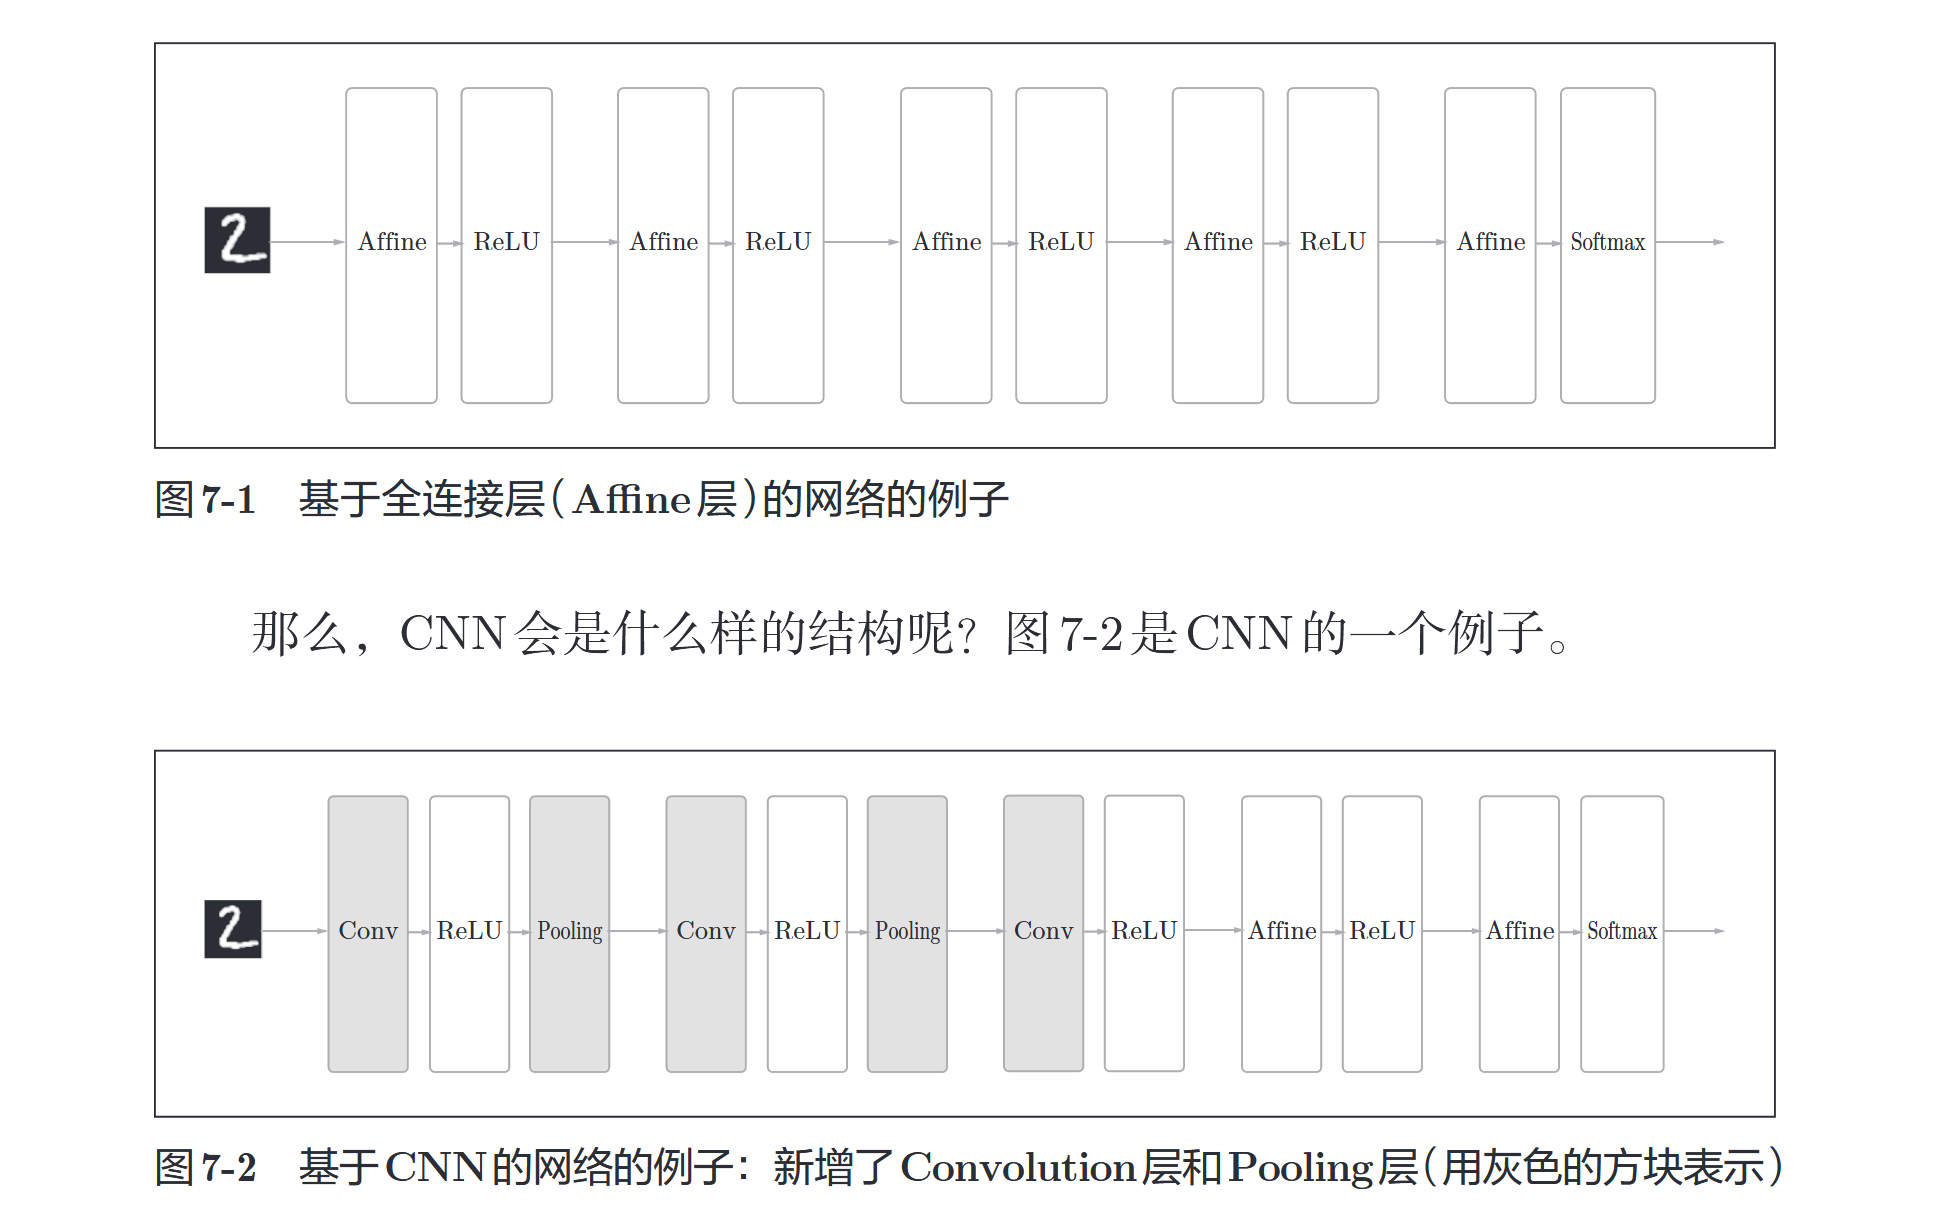

# 2.卷积层和池化层的实现
卷积层可以保持形状不变。当输入数据是图像时，卷积层会以 3 维
数据的形式接收输入数据，并同样以 3 维数据的形式输出至下一层
$$

“Max池化”是获取最大值的运算


In [1]:
import numpy as np
x = np.random.rand(10, 1, 28, 28) # 随机生成数据:对应 10 个通道为 1 、高为 28、长为 28的数据 (4 维数组)
x.shape
print(x[0, 0] ) # 或者 x[0][0] 访问第 1 个数据的第 1 个通道的空间数据

[[6.20119757e-02 4.96051100e-01 2.19188459e-01 7.04652073e-01
  9.70842519e-01 2.42594838e-02 2.31074497e-01 3.67974379e-01
  8.89742334e-01 7.07326460e-01 4.23014776e-01 2.50699313e-01
  1.73808550e-01 5.90878194e-01 9.07009482e-02 2.40262480e-01
  6.30194557e-01 9.13592829e-01 3.03901321e-01 7.03985939e-01
  7.52120443e-02 5.29405650e-01 9.64926356e-01 9.25653332e-01
  7.11363303e-02 5.63828426e-01 8.84374361e-02 7.43402603e-01]
 [9.57513816e-01 6.01277069e-01 8.52167727e-01 5.31178561e-01
  8.86879262e-01 8.32671366e-01 6.13873991e-01 2.97883520e-01
  4.41507277e-01 6.30801471e-01 5.77885983e-02 5.98076968e-01
  6.75663309e-02 6.27781126e-01 7.50305264e-02 6.63556520e-01
  5.52482425e-01 8.18353284e-01 7.77871785e-01 5.61034993e-01
  1.88399439e-01 1.55528746e-01 7.52442972e-01 3.28198034e-01
  5.67848303e-01 6.18421063e-02 9.56904907e-01 2.89521626e-01]
 [1.28700183e-01 3.66991138e-01 7.76094759e-01 2.58322808e-01
  9.51358682e-01 9.07866808e-01 4.99745871e-01 9.60953914e-01
  6.30

In [2]:
# NumPy中，访问元素时最好不要用 for 语句；实现卷积运算使用for会重复好几层，导致处理变慢
# im2col 会把输入数据展开以适合滤波器（权重）
def im2col(input_data, filter_h, filter_w, stride=1, pad=0): #只是数据重组
    """

    Parameters
    ----------
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
 
    for y in range(filter_h): # 滤波器高度方向
        y_max = y + stride*out_h
        for x in range(filter_w):  #滤波器宽度方向
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride] # 提取所有样本、所有通道、所有输出位置对应的像素
            #当(y,x)=(0,0)时：提取所有左上角像素；当(y,x)=(0,1)时：提取所有右上角像素
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col #这一步是为了构建权重矩阵，目的是要用权重矩阵

In [3]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)
x2 = np.random.rand(10, 3, 7, 7) # 10 个数据
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)


(9, 75)
(90, 75)


In [4]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col
x3 = np.random.rand(1, 3, 4, 4)
col3 = im2col(x3, 2, 2, stride=1, pad=0)
print(col3.shape) # (9, 12)
#会在高度和宽度方向各产生 3 个位置（滤波器扫描），总共有 3×3=9 个窗口位置（第一个维度 9：表示输出特征图的空间位置数（即卷积窗口的数量））
#第二个维度 12：表示每个卷积窗口展开后的元素总数 ：元素数 = 通道数×过滤器高度×过滤器宽度 元素数=3×2×2=12，im2col 将这些元素展平为一列

(9, 12)


In [5]:
#在数学上，卷积可以表示为：卷积结果 = im2col(输入) × 滤波器矩阵
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W # 滤波器权重 (FN, C, FH, FW)
        self.b = b # 偏置 (FN,)
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        FN, C, FH, FW = self.W.shape # 滤波器数量，通道数，高度，宽度
        N, C, H, W = x.shape # 批大小，通道数，输入高度，宽度
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad) # 形状 (N*out_h*out_w, C*FH*FW)
        col_W = self.W.reshape(FN, -1).T # 滤波器的展开，形状 (C*FH*FW, FN)
        out = np.dot(col, col_W) + self.b # 形状(N*out_h*out_w, FN)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out  # 形状 (N, FN, out_h, out_w)

In [6]:
W = np.random.randn(4, 3, 2, 2)  # (FN=4, C=3, FH=2, FW=2)
col_W = W.reshape(4, 12).T  # 转置后形状 (12, 4)

In [7]:
#例
import numpy as np

# 创建卷积层实例
W = np.random.randn(2, 3, 2, 2)  # 2个滤波器, 3通道, 2×2
b = np.array([0.1, 0.2])         # 每个滤波器一个偏置
conv_layer = Convolution(W, b, stride=1, pad=0)

# 创建输入数据 (1个样本, 3通道, 4×4)
x = np.random.rand(1, 3, 4, 4)

# 执行前向传播
output = conv_layer.forward(x)

print("输入形状:", x.shape)
print("输出形状:", output.shape)
print(x)
print(output)

输入形状: (1, 3, 4, 4)
输出形状: (1, 2, 3, 3)
[[[[0.36902818 0.12098727 0.91035104 0.11404919]
   [0.16333867 0.53187565 0.91795868 0.29345024]
   [0.45824623 0.10586169 0.11459275 0.87509554]
   [0.29934764 0.12073944 0.97409557 0.05147228]]

  [[0.84280224 0.32892946 0.10179199 0.50714598]
   [0.97466012 0.11849101 0.70916196 0.83827971]
   [0.37770301 0.62301691 0.6798755  0.66418541]
   [0.8742807  0.30096937 0.6224656  0.72765995]]

  [[0.97542531 0.10730493 0.74662445 0.84309404]
   [0.27506904 0.91144153 0.07500071 0.81624738]
   [0.58233941 0.48511518 0.26294983 0.33486284]
   [0.26410556 0.80689925 0.46627466 0.07937125]]]]
[[[[ 0.86056307  0.90529022 -3.67694439]
   [ 0.39080781  1.06552671 -1.14424095]
   [-1.17776679  0.4579121  -1.83986111]]

  [[-0.51579684 -0.62996779 -0.66904974]
   [ 0.31680438 -1.83377719 -0.42314519]
   [ 0.2161903  -1.59560222 -1.10840384]]]]


In [8]:
#池化层
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # 展开 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 最大值 (2)
        out = np.max(col, axis=1)
        # 转换 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out
#1. 展开输入数据。
#2. 求各行的最大值。
#3. 转换为合适的输出大小

#     3. CNN完整

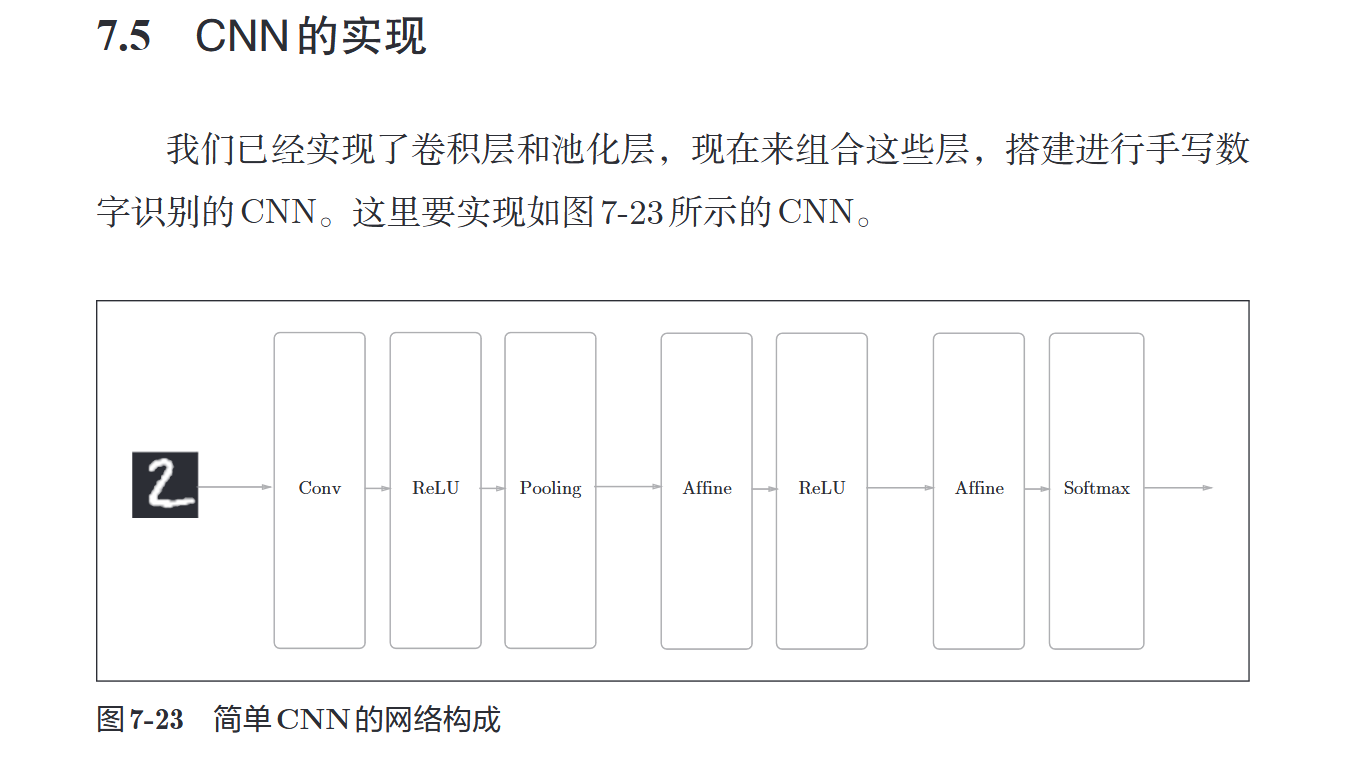

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},  #卷积层字典，分别是滤波器数量、大小、填充、步幅
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1 # 卷积层输出尺寸 24x24
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))  # 池化层输出尺寸 30×12×12=4320 ；除于2说明是2x2池化

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size) #30个卷积核，每个卷积核是1通道×5×5 (30, 1, 5, 5) ；滤波器权重！随机产生会更新！
        self.params['b1'] = np.zeros(filter_num) #形状: (30,) → 每个卷积核一个偏置
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size) #将池化层输出的4320维向量映射到100维隐藏层
        self.params['b2'] = np.zeros(hidden_size) #形状: (100,)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size) #将100维隐藏层映射到10维输出（如10分类） ；通过构建的这些W--权重矩阵
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],  #卷积层
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu() #逐元素应用 ReLU 函数: max(0, x)
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2) #输出展平为 30*12*12=4320 维向量（隐式操作）
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2']) #输入: 4320维 → 输出: 100维
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3']) #输入: 100维 → 输出: 10维

        self.last_layer = SoftmaxWithLoss() #组合 softmax 和交叉熵损失

    def predict(self, x): #输入图像 → 卷积层 → ReLU层 → 池化层 → 全连接层 → 输出层 每一层都会有类含有forward的函数
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.3000792165300705
=== epoch:1, train acc:0.157, test acc:0.184 ===
train loss:2.297935514194925
train loss:2.2943209716325645
train loss:2.2889605977807275
train loss:2.2782557388890994
train loss:2.2713378171897065
train loss:2.256394932514028
train loss:2.240341469257393
train loss:2.2187633625850287
train loss:2.194720534677558
train loss:2.1600930675717667
train loss:2.101990116041138
train loss:2.098104850984684
train loss:2.032301123871782
train loss:2.013075793946127
train loss:1.9214464181348836
train loss:1.88434001663818
train loss:1.7690908080875716
train loss:1.7209477462475362
train loss:1.6631780531128662
train loss:1.6434370059733499
train loss:1.4348466331989242
train loss:1.472863163935247
train loss:1.2933603232215916
train loss:1.2809915995840813
train loss:1.250109306882684
train loss:1.143752819646155
train loss:1.0691423844156622
train loss:0.9310426633930475
train loss:1.0470436697006142
train loss:0.8760144509646574
train loss:0.9175110027404101
trai

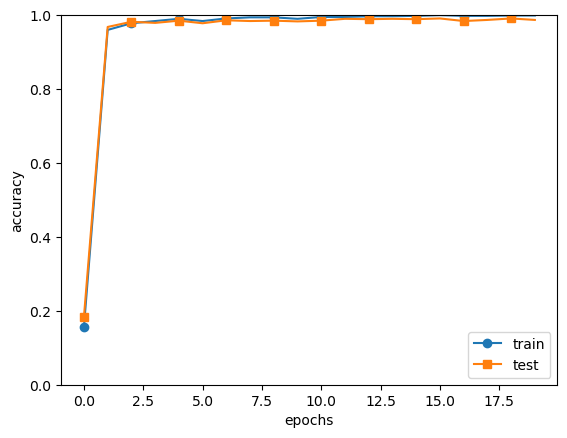

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
